<a href="https://colab.research.google.com/github/dpriyabijosh/Depression_detection/blob/main/DepressionDetection_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

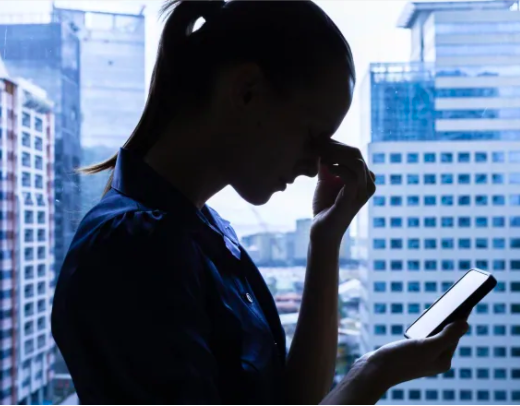

Depression is a mental illness that affects the quality of life which can lead to suicide. The major problem of the illness is that the chance of not knowing about the symptoms are very high. As per WHO, 280 million people world-wide suffer with this illness. The illness got worse due to the pandemic situation and a lot of people committed suicide which makes the importance to detect it in the early stages (Stephen & Prabu, 2019). It can be quite challenging for health care organisations to identify depression in the early stages because people are reluctant to seek care when necessary or uninformed of their mental state. In this era, people are very comfortable expressing their emotions in social media as posts, messages, and comments rather than speaking or sharing their emotions to other individuals (Burdisso et al., 2019). Social networking platforms represent a person’s personal life (Stephen & Prabu, 2019) which can be used for identifying the symptoms of mental illness such as depression by using natural language processing (NLP) with machine learning(ML) techniques. 

This implementation is to create a framework to detect early stage depression symptoms using different machine learning models.

## 1. Install and Load Essential Libraries

In [ ]:
!pip install wordcloud
!pip install nltk
!pip install contractions
import contractions
import os
import re
import nltk
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from google.colab import drive
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
import gensim 
from gensim.models import Word2Vec 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import trange, tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from textblob import TextBlob
from nltk.tokenize import TweetTokenizer
import torch

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 6.6 MB/s 
     |████████████████████████████████| 287 kB 48.2 MB/s 


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. Set up GPU for training

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

`Runtime -> Change runtime type -> Hardware accelerator: GPU`

Then we need to run the following cell to specify the GPU as the device.

In [ ]:
import torch
def set_Cuda():
  if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
  else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# 3. Dataset

# Data Wrangling and EDA
The data file is uploaded to drive and fetching the data by connecting to google drive which contains 8000 depressed and 2314 non-depressed tweets. All observations are annotated: 0 means non-depressed and 1 means depressed.

We will be renaming the old columns to meaningful `tweet` and `label`  corresponding to the column values and dropping the unwanted user id column.

In [ ]:
def initail_dataload():
    # Connect to google drive
    drive.mount('/content/drive')
    path="/content/drive/My Drive/Colab Notebooks"
    os.chdir(path)

    # Load data and set labels
    data_original = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sentiment_tweets3.csv')

    #Drop unwanted column
    data = data_original.drop(data_original.columns[[0]],axis = 1)

    #Rename the columns
    data.rename(columns={'message to examine' :'raw_tweet','label (depression result)': 'label'},inplace=True)

    # Display 5 random samples
    return data

#Need to remove the underline code

In [ ]:
data = initail_dataload()
#View data
data.sample(5)

Mounted at /content/drive


,raw_tweet,label
4605,@lovemeavamp Have a good one Nighty night!,0
7758,@meinrosebud and live like its your last day ...,0
3270,@d0opeb0ii sadly you may be right,0
6691,school's canceled... bummer. but its also okay.,0
2882,is gearing up for flying the dance show and bu...,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   raw_tweet  10314 non-null  object
 1   label      10314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.3+ KB


In [ ]:
#check for null
data.isnull().sum()

raw_tweet    0
label        0
dtype: int64

The data is not having any null values. So we don't need to do any imputation techniques.

In [ ]:
#count for each class
data.label.value_counts()

0    8000
1    2314
Name: label, dtype: int64

The data is heavly imbalanced with 8000 non-depressed and 2314 depressed data.

##Creating WordCloud

In [ ]:
def wordcloud(data, value, text_column):
  words = ' '.join(list(data[data['label'] == value][text_column]))
  set_wordcloud = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(words)
  plt.figure(figsize = (10, 8), facecolor = 'k')
  plt.imshow(set_wordcloud)
  plt.axis('off')
  plt.tight_layout(pad = 0)
  plt.show()

### Depressive WordCloud

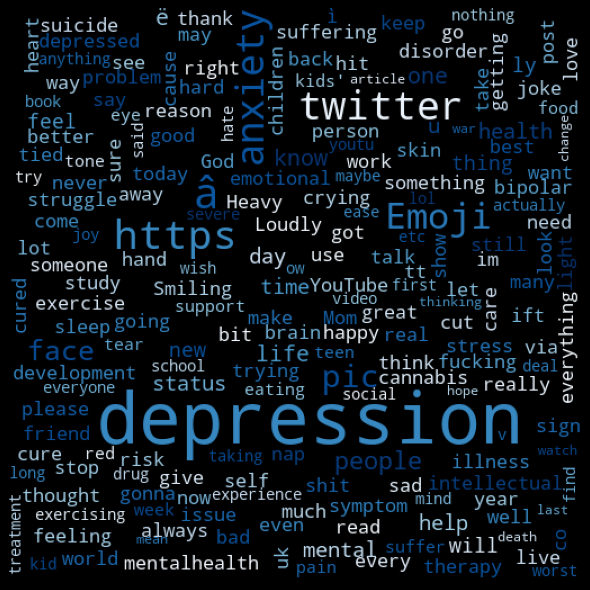

In [ ]:
wordcloud(data, 1, 'raw_tweet')

###Non-depressive wordCloud

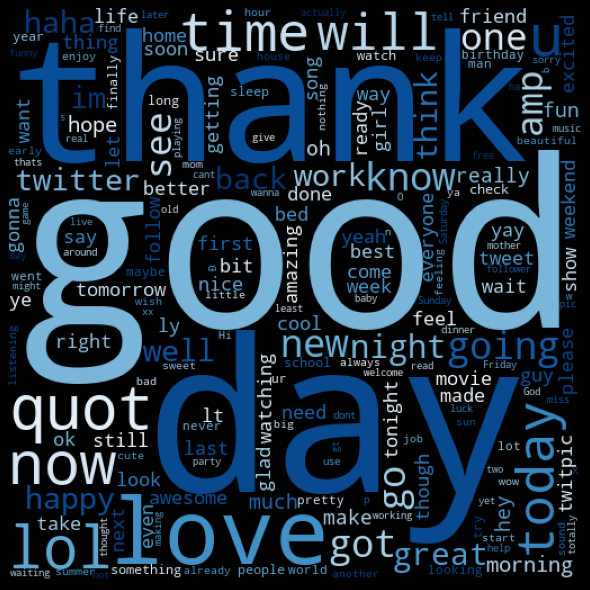

In [ ]:
wordcloud(data, 0, 'raw_tweet')

##Feature Engineering: New features : Don't know good 
Compare with base and then find these features will make any impact on the model performance

In [ ]:
data_feature = data.copy()

In [ ]:
from nltk.corpus.reader import string_category
import string

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100
def count_emoji(text):
    return text.count("Emoji")
def count_hashtag(text):
    return text.count("#")

data_feature['body_len'] = data_feature['raw_tweet'].apply(lambda x: len(x) - x.count(" "))
data_feature['punct%'] = data_feature['raw_tweet'].apply(lambda x: count_punct(x))
data_feature['hashtag%'] = data_feature['raw_tweet'].apply(lambda x: count_emoji(x))
data_feature.head(5)

,raw_tweet,label,body_len,punct%,hashtag%
0,just had a real good moment. i missssssssss hi...,0,46,4.3,0
1,is reading manga http://plurk.com/p/mzp1e,0,38,15.8,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0,80,18.8,0
3,@lapcat Need to send 'em to my accountant tomo...,0,113,7.1,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0,40,12.5,0


In [ ]:
def create_hist(data, new_feature_nm):
  bins = np.linspace(0, 1, 10)
  plt.hist(data[data['label']==0][new_feature_nm], bins=10, alpha=0.5,  label= 'Non-depressed')
  plt.hist(data[data['label']==1][new_feature_nm], bins=10, alpha=0.5,  label='Depressed')
  plt.legend(loc='upper right')
  plt.show()

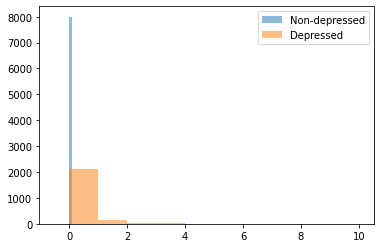

In [ ]:
create_hist(data_feature,'hashtag%')

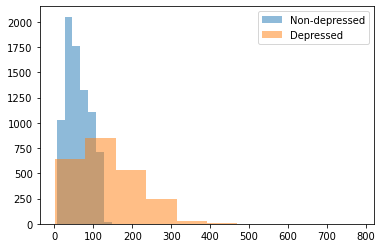

In [ ]:
create_hist(data_feature,'body_len')

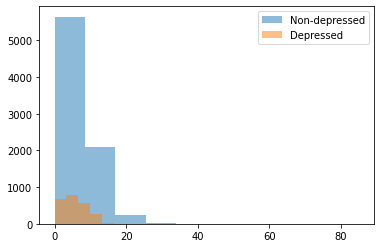

In [ ]:
create_hist(data_feature,'punct%')

### 3. Preprocessing

In the bag-of-words model, a text is represented as the bag of its words, disregarding grammar and word order. Therefore, we will want to remove stop words, punctuations and characters that don't contribute much to the sentence's meaning.

In [ ]:
#Define punctuation symbols
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'      

#Functions to clean tweets
def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_username(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

def remove_stopword(tweet):
    # Remove stopwords except 'not' and 'can'
    tweet = " ".join([word for word in tweet.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    return tweet

""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def replaceElongated(word):
    """ Replaces an elongated word with its basic form, unless the word exists in the lexicon """
    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word

def autoCorrectSentence(sentence):
    sentence = TextBlob(sentence)
    result = sentence.correct()
    return result

def basic_clean(tweet):
    """Main master function to clean tweets only without tokenization or removal of stopwords"""
    tweet = remove_username(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = remove_stopword(tweet)
    tweet = tweet.lower() 
    tweet = replaceContraction(tweet)
     # lower case
    tweet = re.sub(r"\'t", " not", tweet) # replace /t to not
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub(r"emoji"," ",tweet)
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    #tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    tweet = re.sub('📝 …', '', tweet)
    tweet = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', tweet)  # Isolate and remove punctuations except '?'
    tweet = re.sub(r'[^\w\s\?]', ' ', tweet)
    #tweet = re.sub(r'([\;\:\|•«\n])', ' ', tweet) # Remove some special characters
    tweet = re.sub(r'\s+', ' ', tweet).strip() # Remove trailing whitespace   
    tweet = re.sub('[^a-zA-Z\']', ' ', tweet) # Replace everything not a letter or apostrophe with a space
    tweet = ' '.join( [w for w in tweet.split() if len(w)>1] ) # Remove single letter words
    return tweet

In [ ]:
data['tweet'] = data.raw_tweet.apply(basic_clean)

In [ ]:
data.tail(5)

,raw_tweet,label,tweet
10309,No Depression by G Herbo is my mood from now o...,1,no depression herbo mood on am done stressing ...
10310,What do you do when depression succumbs the br...,1,what depression succumbs brain makes feel like...
10311,Ketamine Nasal Spray Shows Promise Against Dep...,1,ketamine nasal spray shows promise against dep...
10312,dont mistake a bad day with depression! everyo...,1,do not mistake bad day depression everyone em
10313,0,1,


In [ ]:
#Drop unwanted columns 
data = data.drop(data.columns[[0]],axis = 1)
data.sample(5)

,label,tweet
2178,0,should coming
2763,0,three minutes pm hahaha lol random
7574,0,just signed badoo seems pretty good
8156,1,magnesium can decrease depression symptoms
6488,0,last day work days


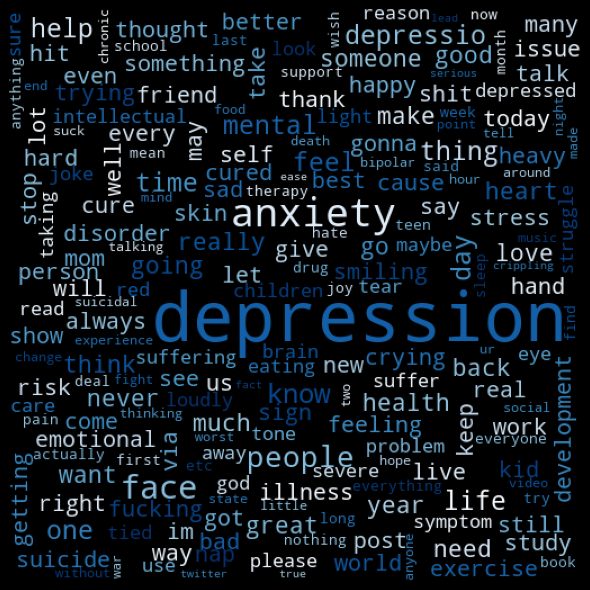

In [ ]:
#Depressive wordCloud
wordcloud(data, 1, 'tweet')

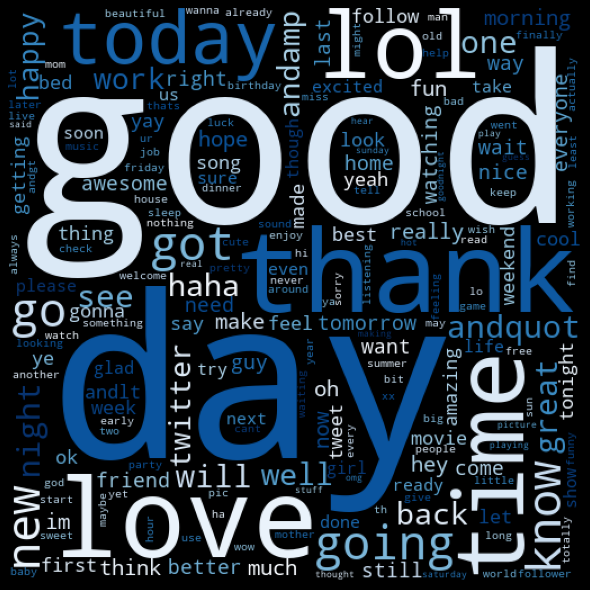

In [ ]:
#Non-depressive wordCloud
wordcloud(data, 0, 'tweet')

## Data cleaning after pre-processing the data

In [ ]:
# Remove rows with empty tweets
print('Total number of empty tweets\n',data[data['tweet']==''].sum())
print(data.shape)

Total number of empty tweets
 label    7
tweet     
dtype: object
(10314, 2)


In [ ]:
def clean_empty_rows(data,column):
  print('Initial size', data.shape)
  sum = data[data[column]==''].sum()
  filter = data[column] != ""
  data = data[filter]
  print('Shape after cleaning',data.shape)
  return data

In [ ]:
data = clean_empty_rows(data,'tweet')

Initial size (10314, 2)
Shape after cleaning (10280, 2)


#Lemmatization

In the bag-of-words model, a text is represented as the bag of its words, disregarding grammar and word order. Therefore, we will want to remove stop words, punctuations and characters that don't contribute much to the sentence's meaning.

In [ ]:
def lemmatize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for tweet in gensim.utils.simple_preprocess(tweet):
        #if (tweet not in gensim.parsing.preprocessing.STOPWORDS or tweet not in ['not', 'can']):  # drops words with 3 or less characters
            result.append(lemmatize_stemming(tweet))
    return result


def lemmatize_stemming(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')


def clean_tweet(tweets, bigrams=False):
    """Main master function to clean tweets, stripping noisy characters and tokenizing use lemmatization"""
    tweet = basic_clean(tweets)
    tweet_token_list = lemmatize(tweet)  # apply lemmatization and tokenization

    if bigrams:
        tweet_token_list = tweet_token_list + [tweet_token_list[i] + '_' + tweet_token_list[i + 1]
                                               for i in range(len(tweet_token_list) - 1)]
    tweet = ' '.join(tweet_token_list)
    return tweet


def tokenize_tweets(tweets):
  tokenizer=TweetTokenizer()
  print(tokenizer.tokenize(tweets.lower()))
  return tokenizer.tokenize(tweets.lower())

### Apply Lemmatization on the cleaned data

In [ ]:
#data['tokenize_tweet'] = data['tweet'].apply(tokenize_tweets)
data['tweet'] = data['tweet'].apply(clean_tweet)

In [ ]:
data.head(5)

,label,tweet
0,0,real good moment miss much
1,0,read manga
3,0,eed send em accountant tomorrow oddly even ref...
4,0,add myspace myspace com lookthunder
5,0,sleepy good time tonight though


In [ ]:
data = clean_empty_rows(data,'tweet')

Initial size (10280, 2)
Shape after cleaning (10260, 2)


In [ ]:
# Function to retrieve cleaned data
def final_clean_data():
  data = initail_dataload()
  #Rename the columns
  data.rename(columns={'raw_tweet' :'tweet'},inplace=True)
  data['tweet'] = data['tweet'].apply(clean_tweet)
  data = clean_empty_rows(data,'tweet')
  return data
final_clean_data()